In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy
import random

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [2]:
# parameters for CSTR
T_0_cstr = 300
V_cstr = 1
k_0_cstr = 8.46*(np.power(10,6))
C_p_cstr = 0.231
rho_L_cstr = 1000
Q_s_cstr = 0.0
F_cstr = 5
E_cstr = 5*(np.power(10,4))
delta_H_cstr = -1.15*(np.power(10,4))
R_cstr = 8.314
C_A0s_cstr = 4

t_final_cstr = 0.005
t_step_cstr = 1e-4

# parameters for Batch
V_batch = 1
k_0_batch = 8.46*(np.power(10,7))
C_p_batch = 0.231
rho_L_batch = 1000
Q_s_batch = 0
E_batch = 5*(np.power(10,4))
delta_H_batch = -1.15*(np.power(10,4))
R_batch = 8.314

t_final_batch = 0.05
t_step_batch = 1e-4

# parameters for PFR
k_0_PFR = 8.46 * (np.power(10,6))
C_p_PFR = 0.231
rho_L_PFR = 1000
u_PFR = 2 # volumetric flow rate  (F/A) Superficial velocity
E_by_R_PFR = 5*(np.power(10,4)) / 8.314
delH_term_PFR = -1.15*(np.power(10,4))
U_PFR = 25
Tc_s_PFR = 293
At_PFR = 0.01 # Area for heating rate equation
A_PFR = 0.002  # Area
length_PFR = 1 # total length of reactor
N_PFR = 10     # number of points to discretize the reactor

t_final_PFR = 0.1
t_step_PFR = 0.01

# parameters for neural networks
num_step = 10
num_dims = 4

# parameters for Reptile
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerstepsize = 0.02 # stepsize in inner SGD for reptile
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 1500 # number of outer updates; each iteration we sample one task and update on it
epochs = 1 # number of epochs
ntrain = 32 # size of training minibatches (K)
eval_step = 50 # evaluation step
threshold = 10 # threshold to check data correctness

In [3]:
def generate_new_1000(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_100(x):
    return x + x * np.random.uniform(-1, 1)

def generate_new_5(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def generate_new_Tc_s(x):
    return x + x * np.random.uniform(-0.068259, 1)

def PFR_simulation(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T, length, N):

    # Method of lines approximates the spatial derivative using finite difference method which reults in a set of coupled ODE

    def method_of_lines_C(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(C) / np.diff(z) - k_0 * np.exp(-E_by_R/T[1:]) * C[1:]    # for first order
        return np.concatenate([[0], D]) #C0 is constant at entrance


    def method_of_lines_T(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(T) / np.diff(z) + (-delH_term/(rho_L*C_p)) * k_0 * np.exp(-E_by_R/T[1:])* C[1:] + (U/(rho_L*C_p*A)) * At * (Tc - T[1:]) # for first order
        return np.concatenate([[0], D]) #T0 is constant at entrance

    z = np.linspace(0, length, N) # discretized length elements

    #initializing arrays
    init_C_A_2_1 = np.zeros(N)
    init_T_2_1 = np.zeros(N)

    init_C_A_2_2 = np.zeros(N)
    init_T_2_2 = np.zeros(N)

    init_C_A_3 = np.zeros(N)
    init_T_3 = np.zeros(N)

    C_A_3 = np.zeros(N)
    T_3 = np.zeros(N)

    dCAdt1 = method_of_lines_C(init_C, init_T)
    dTdt1 = method_of_lines_T(init_C, init_T)

    for i in range(len(init_C)):
        init_C_A_2_1[i] = init_C[i] + dCAdt1[i] * t_step / 2
        init_T_2_1[i] = init_T[i] + dTdt1[i] * t_step / 2

    dCAdt2_1 = method_of_lines_C(init_C_A_2_1, init_T_2_1)
    dTdt2_1 = method_of_lines_T(init_C_A_2_1, init_T_2_1)

    for i in range(len(init_C)):
        init_C_A_2_2[i] = init_C[i] + dCAdt2_1[i] * t_step / 2
        init_T_2_2[i] = init_T[i] + dTdt2_1[i] * t_step / 2

    dCAdt2_2 = method_of_lines_C(init_C_A_2_2, init_T_2_2)
    dTdt2_2 = method_of_lines_T(init_C_A_2_2, init_T_2_2)

    for i in range(len(init_C)):
        init_C_A_3[i] = init_C[i] + dCAdt2_2[i] * t_step / 2
        init_T_3[i] = init_T[i] + dTdt2_2[i] * t_step / 2

    dCAdt3 = method_of_lines_C(init_C_A_3, init_T_3)
    dTdt3 = method_of_lines_T(init_C_A_3, init_T_3)

    dCAdt2 = np.add(dCAdt2_1,dCAdt2_2)
    dCAdt2 = np.divide(dCAdt2,2)

    dTdt2 = np.add(dTdt2_1,dTdt2_2)
    dTdt2 = np.divide(dTdt2,2)

    for i in range(len(init_C)):
        C_A_3[i] = init_C[i] + t_step / 6 * (dCAdt1[i] + 4*dCAdt2[i] + dCAdt3[i])
        T_3[i] = init_T[i] + t_step / 6 * (dTdt1[i] + 4*dTdt2[i] + dTdt3[i])

    return C_A_3 , T_3

def Batch_simulation(V, k_0, E, R, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating Batch using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = -k_0 * np.exp(-E / (R * T)) * C_A
        dTdt = - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 50 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [4]:
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step, num_dims):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new_100(T_0)
        V_new = generate_new_1000(V)
        F_new = generate_new_1000(F)
        C_A0s_new = generate_new_100(C_A0s)
        Q_s_new = generate_new_1000(Q_s)
        rho_L_new = generate_new_5(rho_L)
        C_p_new = generate_new_5(C_p)
        k_0_new = generate_new_5(k_0)
        E_new = generate_new_5(E)
        delta_H_new = generate_new_5(delta_H)

        # generating inputs and initial states for CSTR
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of CSTR: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [5]:
def gen_batch(V, k_0, E, R, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step, num_dims):
    isCorrect = False
    while isCorrect == False:
        V_new = generate_new_1000(V)
        Q_s_new = generate_new_1000(Q_s)
        rho_L_new = generate_new_5(rho_L)
        C_p_new = generate_new_5(C_p)
        k_0_new = generate_new_1000(k_0)
        E_new = generate_new_5(E)
        delta_H_new = generate_new_5(delta_H)

        # generating inputs and initial states for Batch
        u_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 40, endpoint=True)
        CA_initial = np.linspace(0, 6, 40, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u_list:
            Q = u1 + Q_s_new
            for C_A_initial, T_initial in x_deviation:

                C_A_list, T_list = Batch_simulation(V_new, k_0_new, E_new, R, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                    CA0_input.append(0)
                    Q_input.append(u1)
                    CA_input.append(C_A_initial)
                    T_input.append(T_initial)

                    CA_output.append(C_A_list)
                    T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, Q_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of Batch: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [6]:
def gen_pfr(u, delH_term, k_0, C_p, rho_L, E_by_R, U, At, A, Tc_s, length, N, t_final, t_step, num_step, num_dims):
    isCorrect = False
    while isCorrect == False:
        u_new = generate_new_100(u)
        U_new = generate_new_100(U)
        A_new = generate_new_1000(A)
        At_new = generate_new_1000(At)
        Tc_s_new = generate_new_Tc_s(Tc_s)
        rho_L_new = generate_new_5(rho_L)
        C_p_new = generate_new_5(C_p)
        k_0_new = generate_new_5(k_0)
        E_by_R_new = generate_new_5(E_by_R)
        delH_term_new = generate_new_5(delH_term)

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u_list = np.linspace(100, 300, 4, endpoint=True)
        T_initial = np.linspace(300, 500, 40, endpoint=True)
        CA_initial = np.linspace(0.5, 3, 40, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for physics-informed model
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        Tc_input = list()
        CA0_input = list()

        for u2 in u_list:
            Tc = u2 + Tc_s_new

            for C_A_initial, T_initial in x_deviation:

                z = np.linspace(0, length, N) # discretized length elements

                init_C = np.zeros(N)    # Concentration in reactor at t = 0
                init_C[0] = C_A_initial          # concentration at entrance
                init_T = np.zeros(N)    # T in reactor at t = 0
                for i in range(len(init_T)):
                    if i == 0:
                        init_T[i] = T_initial
                    else:
                        init_T[i] = Tc_s_new

                C_A_list = list()
                T_list = list()

                for i in range(int(t_final / t_step)):

                    CA_next, T_next = PFR_simulation(u_new, delH_term_new, k_0_new, C_p_new, rho_L_new, E_by_R_new, Tc, U_new, At_new, A_new, t_final, t_step, init_C, init_T, length, N)
                    if i % 1 == 0:
                        C_A_list.append(CA_next)
                        T_list.append(T_next)
                    init_C = CA_next
                    init_T = T_next
                if any(abs(i) < 0.001 for i in np.array(T_list)[:,1]) == False and any(abs(i) < 0.001 for i in np.array(C_A_list)[:,1]) == False and any(abs(i) > 10000 for i in np.array(T_list)[:,1]) == False and any(abs(i) > 10000 for i in np.array(C_A_list)[:,1]) == False and any(abs(i) == 0 for i in np.array(T_list)[:,1]) == False and any(abs(i) == 0 for i in np.array(C_A_list)[:,1]) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                    CA0_input.append(0)
                    Tc_input.append(u2)
                    CA_input.append(C_A_initial)
                    T_input.append(T_initial)

                    CA_output.append(C_A_list)
                    T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:
            
            CA_output = np.array(CA_output)[:,:,1]
            T_output = np.array(T_output)[:,:,1]

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Tc_input = np.array(Tc_input)
            Tc_input = Tc_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Tc_input, Tc_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of PFR: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [7]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_2 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, num_dims)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [8]:
# generate testing cstr
isOverflow = True
while isOverflow == True:
    try:
        x_test_cstr, y_test_cstr = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step, num_dims)
        isOverflow = False
    except ValueError:
        pass

# generate testing batch
isOverflow = True
while isOverflow == True:
    try:
        x_test_batch, y_test_batch = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step, num_dims)
        isOverflow = False
    except ValueError:
        pass

# generate testing pfr
isOverflow = True
while isOverflow == True:
    try:
        x_test_pfr, y_test_pfr = gen_pfr(u_PFR, delH_term_PFR, k_0_PFR, C_p_PFR, rho_L_PFR, E_by_R_PFR, U_PFR, At_PFR, A_PFR, Tc_s_PFR, length_PFR, N_PFR, t_final_PFR, t_step_PFR, num_step, num_dims)
        isOverflow = False
    except ValueError:
        pass

Number of training samples of CSTR:  6400
Number of training samples of Batch:  6240
Number of training samples of PFR:  6400


In [9]:
# # save the unseen datasets
# with open('x_test_cstr.pkl', 'wb') as f:
#     pickle.dump(x_test_cstr, f)

# with open('y_test_cstr.pkl', 'wb') as f:
#     pickle.dump(y_test_cstr, f)

# with open('x_test_batch.pkl', 'wb') as f:
#     pickle.dump(x_test_batch, f)

# with open('y_test_batch.pkl', 'wb') as f:
#     pickle.dump(y_test_batch, f)

# with open('x_test_pfr.pkl', 'wb') as f:
#     pickle.dump(x_test_pfr, f)

# with open('y_test_pfr.pkl', 'wb') as f:
#     pickle.dump(y_test_pfr, f)

In [20]:
# load the unseen datasets
with open('x_test_cstr.pkl', 'rb') as f:
    x_test_cstr = pickle.load(f)

with open('y_test_cstr.pkl', 'rb') as f:
    y_test_cstr = pickle.load(f)

with open('x_test_batch.pkl', 'rb') as f:
    x_test_batch = pickle.load(f)

with open('y_test_batch.pkl', 'rb') as f:
    y_test_batch = pickle.load(f)

with open('x_test_pfr.pkl', 'rb') as f:
    x_test_pfr = pickle.load(f)

with open('y_test_pfr.pkl', 'rb') as f:
    y_test_pfr = pickle.load(f)

In [21]:
model_reptile = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))
model_transfer = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

In [22]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_cstr = np.zeros(100)
test_loss_reptile_cstr = np.zeros(100)

# results on unseen cstr
for i in range(100):
    sample_idx = rng.choice(len(x_test_cstr), size=i+1)
    xtest_plot = x_test_cstr[sample_idx]
    ytest_plot = y_test_cstr[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_transfer)
    print("transfer loss: ", test_loss_transfer_cstr[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_reptile)
    print("reptile loss: ", test_loss_reptile_cstr[i])

    model_reptile.set_weights(weights_before)

transfer loss:  1.00134288347851
reptile loss:  0.21399315428191354
transfer loss:  0.9241520682249277
reptile loss:  0.1928585006865378
transfer loss:  1.0066730973102318
reptile loss:  0.05721553156370583
transfer loss:  0.9789519959551473
reptile loss:  0.06224099014757799
transfer loss:  0.7280104662571829
reptile loss:  0.050124462509340474
transfer loss:  0.8686751660730464
reptile loss:  0.07191840614203981
transfer loss:  0.922885207333248
reptile loss:  0.08143046417851432
transfer loss:  0.8433888511660724
reptile loss:  0.09180276551753744
transfer loss:  0.758740706014239
reptile loss:  0.04649570541566678
transfer loss:  0.6226254748683477
reptile loss:  0.011723733688426271
transfer loss:  0.681186945572454
reptile loss:  0.010225639345471412
transfer loss:  0.8279598911031598
reptile loss:  0.013347395388212502
transfer loss:  0.6212204379850638
reptile loss:  0.00961900127254258
transfer loss:  0.8193032072275375
reptile loss:  0.02529171997797207
transfer loss:  0.6884

In [23]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_batch = np.zeros(100)
test_loss_reptile_batch = np.zeros(100)

# results on unseen batch
for i in range(100):
    sample_idx = rng.choice(len(x_test_batch), size=i+1)
    xtest_plot = x_test_batch[sample_idx]
    ytest_plot = y_test_batch[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_batch[i] = compute_loss(x_test_batch, y_test_batch, model_transfer)
    print("transfer loss: ", test_loss_transfer_batch[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_batch[i] = compute_loss(x_test_batch, y_test_batch, model_reptile)
    print("reptile loss: ", test_loss_reptile_batch[i])

    model_reptile.set_weights(weights_before)

transfer loss:  1.313871466643524
reptile loss:  0.6989552514417363
transfer loss:  1.1695925473360849
reptile loss:  0.12986727416945557
transfer loss:  0.5836932135352495
reptile loss:  0.06826525154229927
transfer loss:  0.5850937643379368
reptile loss:  0.07947021305190018
transfer loss:  0.48467648922039447
reptile loss:  0.034621254445559455
transfer loss:  0.6861227023241976
reptile loss:  0.04967191417594723
transfer loss:  0.6178083455546286
reptile loss:  0.019583207386880304
transfer loss:  0.5852248151123064
reptile loss:  0.07270482652278162
transfer loss:  0.5717726328834628
reptile loss:  0.04543004310293493
transfer loss:  0.46645796843856846
reptile loss:  0.01927169907268866
transfer loss:  0.5014548376232109
reptile loss:  0.0144923410780657
transfer loss:  0.44577204039224905
reptile loss:  0.026734444203662784
transfer loss:  0.4516580741114269
reptile loss:  0.016313071918232433
transfer loss:  0.4851860161432843
reptile loss:  0.014935951052716251
transfer loss: 

In [24]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_pfr = np.zeros(100)
test_loss_reptile_pfr = np.zeros(100)

# results on unseen pfr
for i in range(100):
    sample_idx = rng.choice(len(x_test_pfr), size=i+1)
    xtest_plot = x_test_pfr[sample_idx]
    ytest_plot = y_test_pfr[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_pfr[i] = compute_loss(x_test_pfr, y_test_pfr, model_transfer)
    print("transfer loss: ", test_loss_transfer_pfr[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_pfr[i] = compute_loss(x_test_pfr, y_test_pfr, model_reptile)
    print("reptile loss: ", test_loss_reptile_pfr[i])

    model_reptile.set_weights(weights_before)

transfer loss:  0.8845355087796288
reptile loss:  0.2970900733990818
transfer loss:  0.6327219920076379
reptile loss:  0.08792148338436495
transfer loss:  0.7421544638576485
reptile loss:  0.21848966059802868
transfer loss:  0.6157407876038739
reptile loss:  0.5411062571567323
transfer loss:  0.5540589692277331
reptile loss:  0.08602536049706963
transfer loss:  0.7058985751816657
reptile loss:  0.16397662450782655
transfer loss:  0.47206994538058406
reptile loss:  0.02444220654860648
transfer loss:  0.47820979032927613
reptile loss:  0.05502441827240837
transfer loss:  0.5028455749819442
reptile loss:  0.023316882250834406
transfer loss:  0.5028064188835264
reptile loss:  0.013053079600182236
transfer loss:  0.44978948293762616
reptile loss:  0.034945614734725856
transfer loss:  0.39550317939179275
reptile loss:  0.012022436543269649
transfer loss:  0.4065959600875093
reptile loss:  0.021946490004476422
transfer loss:  0.3996548120717903
reptile loss:  0.02880071623598537
transfer loss

meta NOT subset; don't know how to subset; dropped


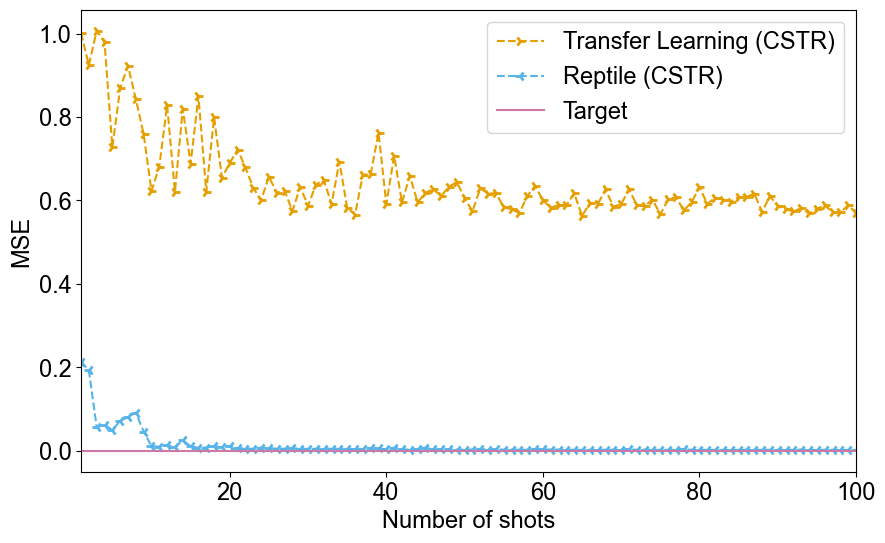

In [28]:
# Testing
test_loss_normal = [0.0005]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_cstr[:size], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (CSTR)')
plt.plot(x, test_loss_reptile_cstr[:size], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (CSTR)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_cstr.pdf')
plt.show()

meta NOT subset; don't know how to subset; dropped


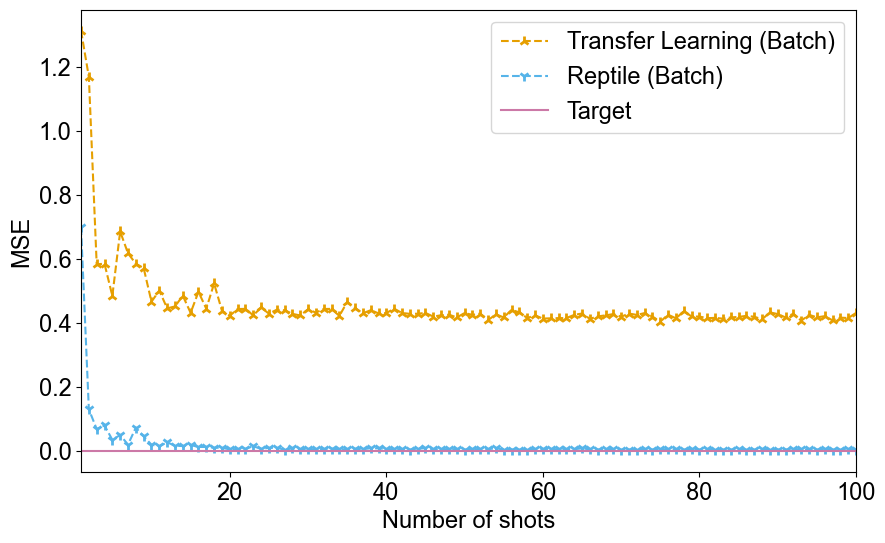

In [29]:
# Testing
test_loss_normal = [0.0005]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_batch[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (Batch)')
plt.plot(x, test_loss_reptile_batch[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (Batch)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_batch.pdf')
plt.show()

meta NOT subset; don't know how to subset; dropped


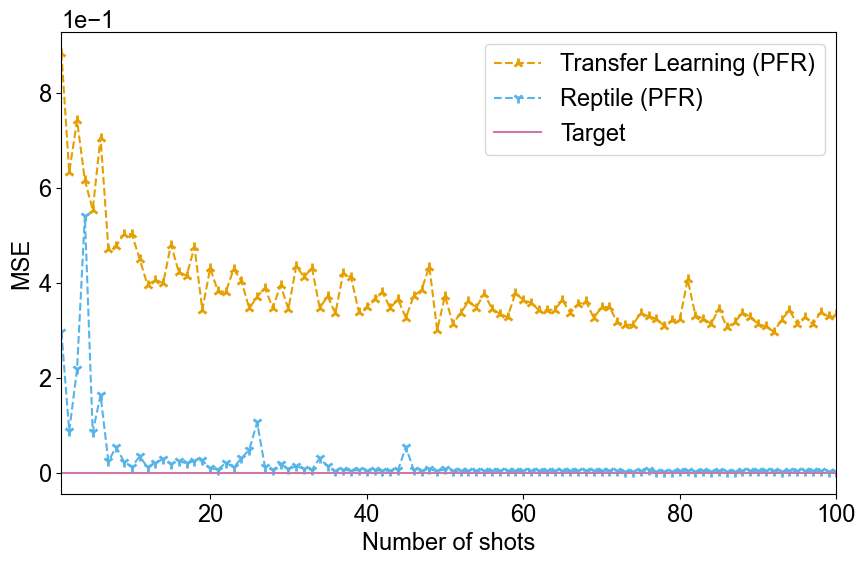

In [30]:
# Testing
test_loss_normal = [0.0005]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_pfr[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (PFR)')
plt.plot(x, test_loss_reptile_pfr[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (PFR)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_pfr.pdf')
plt.show()

In [25]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for CSTR: %f" % (i+1, test_loss_transfer_cstr[i]))
        print("Test loss of reptile using %d-shots for CSTR: %f" % (i+1, test_loss_reptile_cstr[i]))

Test loss of transfer learning using 5-shots for CSTR: 0.728010
Test loss of reptile using 5-shots for CSTR: 0.050124
Test loss of transfer learning using 10-shots for CSTR: 0.622625
Test loss of reptile using 10-shots for CSTR: 0.011724
Test loss of transfer learning using 15-shots for CSTR: 0.688406
Test loss of reptile using 15-shots for CSTR: 0.011395
Test loss of transfer learning using 20-shots for CSTR: 0.689536
Test loss of reptile using 20-shots for CSTR: 0.011712
Test loss of transfer learning using 25-shots for CSTR: 0.657331
Test loss of reptile using 25-shots for CSTR: 0.006494
Test loss of transfer learning using 30-shots for CSTR: 0.587312
Test loss of reptile using 30-shots for CSTR: 0.005109
Test loss of transfer learning using 35-shots for CSTR: 0.582678
Test loss of reptile using 35-shots for CSTR: 0.005099
Test loss of transfer learning using 40-shots for CSTR: 0.592005
Test loss of reptile using 40-shots for CSTR: 0.003741
Test loss of transfer learning using 45-sh

In [26]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for Batch: %f" % (i+1, test_loss_transfer_batch[i]))
        print("Test loss of reptile using %d-shots for Batch: %f" % (i+1, test_loss_reptile_batch[i]))

Test loss of transfer learning using 5-shots for Batch: 0.484676
Test loss of reptile using 5-shots for Batch: 0.034621
Test loss of transfer learning using 10-shots for Batch: 0.466458
Test loss of reptile using 10-shots for Batch: 0.019272
Test loss of transfer learning using 15-shots for Batch: 0.431700
Test loss of reptile using 15-shots for Batch: 0.018273
Test loss of transfer learning using 20-shots for Batch: 0.422549
Test loss of reptile using 20-shots for Batch: 0.004783
Test loss of transfer learning using 25-shots for Batch: 0.429214
Test loss of reptile using 25-shots for Batch: 0.009278
Test loss of transfer learning using 30-shots for Batch: 0.442683
Test loss of reptile using 30-shots for Batch: 0.006455
Test loss of transfer learning using 35-shots for Batch: 0.465617
Test loss of reptile using 35-shots for Batch: 0.005171
Test loss of transfer learning using 40-shots for Batch: 0.431187
Test loss of reptile using 40-shots for Batch: 0.005853
Test loss of transfer lear

In [27]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for PFR: %f" % (i+1, test_loss_transfer_pfr[i]))
        print("Test loss of reptile using %d-shots for PFR: %f" % (i+1, test_loss_reptile_pfr[i]))

Test loss of transfer learning using 5-shots for PFR: 0.554059
Test loss of reptile using 5-shots for PFR: 0.086025
Test loss of transfer learning using 10-shots for PFR: 0.502806
Test loss of reptile using 10-shots for PFR: 0.013053
Test loss of transfer learning using 15-shots for PFR: 0.480514
Test loss of reptile using 15-shots for PFR: 0.018996
Test loss of transfer learning using 20-shots for PFR: 0.430620
Test loss of reptile using 20-shots for PFR: 0.009845
Test loss of transfer learning using 25-shots for PFR: 0.346398
Test loss of reptile using 25-shots for PFR: 0.048982
Test loss of transfer learning using 30-shots for PFR: 0.345130
Test loss of reptile using 30-shots for PFR: 0.008600
Test loss of transfer learning using 35-shots for PFR: 0.372079
Test loss of reptile using 35-shots for PFR: 0.013765
Test loss of transfer learning using 40-shots for PFR: 0.349304
Test loss of reptile using 40-shots for PFR: 0.004389
Test loss of transfer learning using 45-shots for PFR: 0.3

In [31]:
np.savetxt("test_loss_transfer_cstr.txt", test_loss_transfer_cstr, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_cstr.txt", test_loss_reptile_cstr, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_batch.txt", test_loss_transfer_batch, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_batch.txt", test_loss_reptile_batch, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_pfr.txt", test_loss_transfer_pfr, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_pfr.txt", test_loss_reptile_pfr, fmt='%f', delimiter=" ")